Workflow : Load Data → Inspect Data → EDA → Preprocess → Train Model → Evaluate Model → Predict

 Import Libraries

In [16]:
import numpy as np
import pandas as pd
from itertools import cycle
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import argparse




Define Custom Label Encoder

In [2]:
class RobustLabelEncoder:
    def __init__(self):
        self.encoder = {}
        self.default_value = -1

    def fit(self, data):
        unique_values = data.unique()
        self.encoder = {v: i for i, v in enumerate(unique_values)}

    def transform(self, data):
        return data.map(lambda x: self.encoder.get(x, self.default_value))

Load and Inspect Data

In [3]:
train_df = pd.read_csv('/content/cosmicclassifierTraining.csv')
print(train_df.head())
print("Training Data Shape:", train_df.shape)
print("Missing Values:\n", train_df.isna().sum())
print("Columns:", train_df.columns.tolist())
print("Data Types:\n", train_df.dtypes)
target_col = 'Prediction'


   Atmospheric Density  Surface Temperature   Gravity  Water Content  \
0             0.472806                  NaN -0.313872      -2.089299   
1             4.180154            -1.157515  2.430956      -1.595850   
2            -0.129008             1.621592 -0.785741       2.081196   
3            -3.122000            -2.299818  1.072092       0.353524   
4            -1.459426             2.890268  0.148757      -0.804439   

   Mineral Abundance  Orbital Period  Proximity to Star  \
0          -0.152201       -0.885649           0.900105   
1          -3.188678       -0.609434          -0.199828   
2          -1.413796       -0.095152          -3.502577   
3          -0.192529        2.917067          -1.972329   
4           0.494875        0.044910          -0.438796   

  Magnetic Field Strength Radiation Levels  Atmospheric Composition Index  \
0                     NaN       Category_6                       0.692907   
1              Category_9       Category_9                

Exploratory Data Analysis

Prediction
1.0    1047
7.0     994
3.0     951
6.0     945
0.0     937
2.0     920
4.0     909
9.0     906
8.0     871
5.0     795
Name: count, dtype: int64


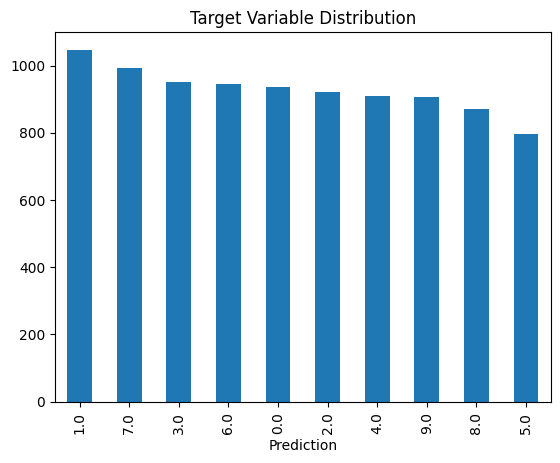

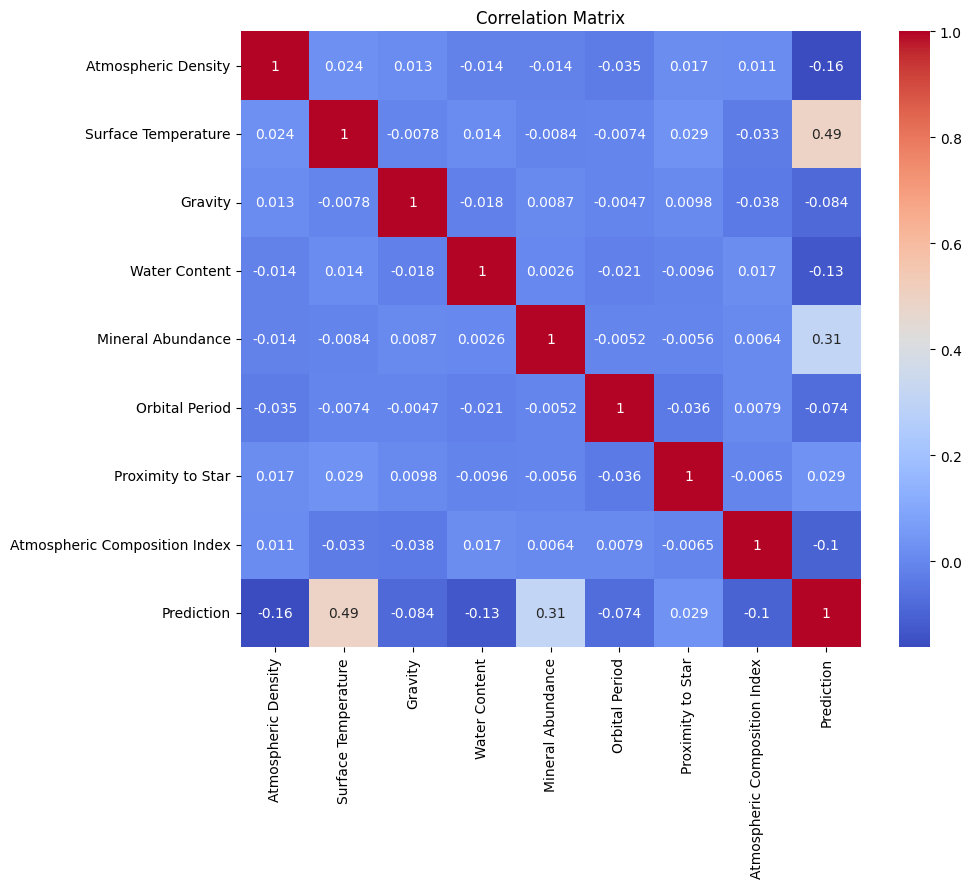

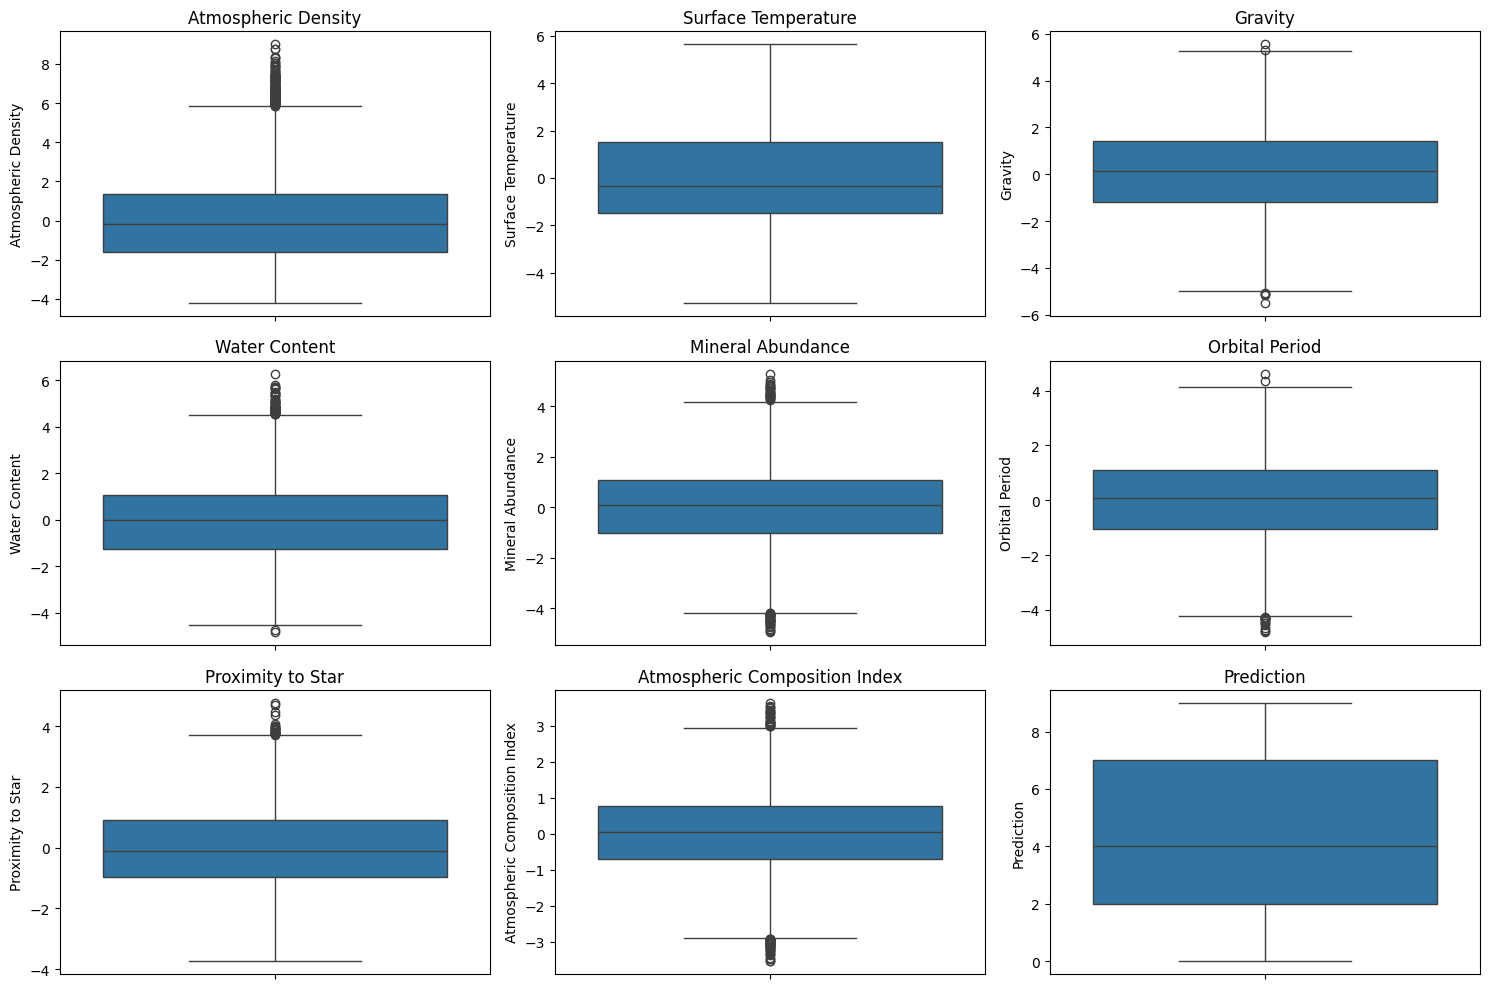

Number of outliers in Atmospheric Density: 170
Number of outliers in Surface Temperature: 0
Number of outliers in Gravity: 7
Number of outliers in Water Content: 61
Number of outliers in Mineral Abundance: 63
Number of outliers in Orbital Period: 18
Number of outliers in Proximity to Star: 27
Number of outliers in Atmospheric Composition Index: 69
Number of outliers in Prediction: 0


In [4]:
print(train_df[target_col].value_counts())
train_df[target_col].value_counts().plot(kind='bar', title='Target Variable Distribution')
plt.show()

numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=train_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    print(f"Number of outliers in {col}: {len(outliers)}")

Data Preprocessing

In [5]:
target_col = 'Prediction'
valid_data = train_df[train_df[target_col].notna()].copy()
features = valid_data.columns.drop([target_col]).tolist()
X = valid_data[features]
y = valid_data[target_col]

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = RobustLabelEncoder()
    le.fit(X[col].astype(str))
    X[col] = le.transform(X[col].astype(str))
    label_encoders[col] = le

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

joblib.dump(imputer, 'imputer.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

<ipython-input-5-2222dffbd015>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.transform(X[col].astype(str))
<ipython-input-5-2222dffbd015>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.transform(X[col].astype(str))


['label_encoders.joblib']

Train-Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Training XGBoost Model

In [17]:
model = XGBClassifier(
    n_estimators=850,
    max_depth=6,
    learning_rate=0.15,
    subsample=0.8,
    colsample_bytree=0.85,
    gamma=0.2,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)
val_accuracy = model.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

model_name = f"xgb_model_{pd.Timestamp.now().strftime('%Y%m%d')}.joblib"
joblib.dump(model, model_name)

Validation Accuracy: 0.8528


['xgb_model_20250305.joblib']

Model Evaluation

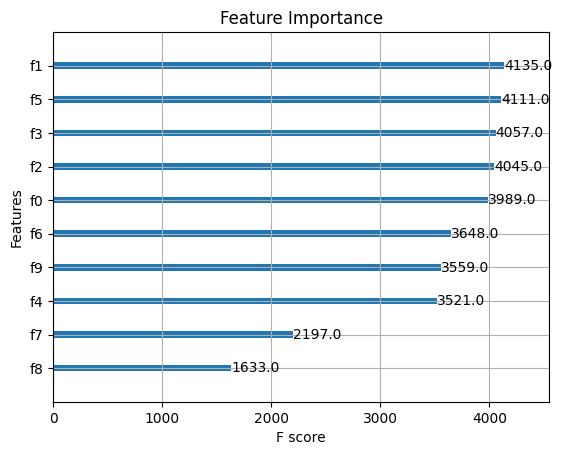

Mean CV Accuracy: 0.8434


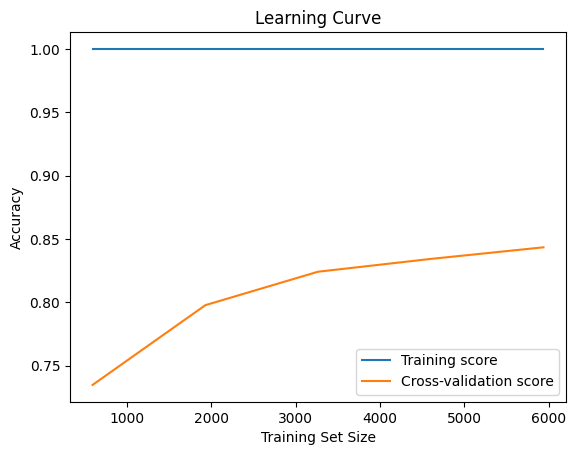

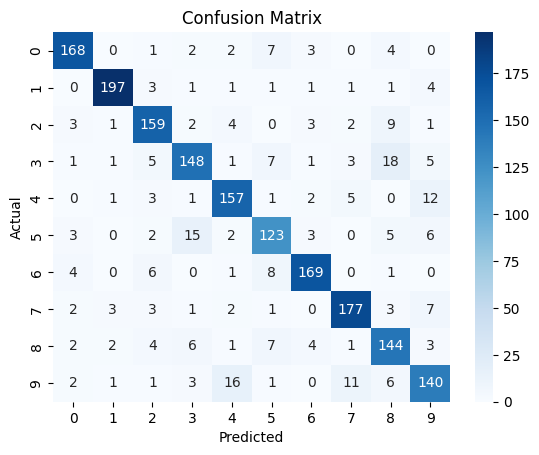

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       187
         1.0       0.96      0.94      0.95       210
         2.0       0.85      0.86      0.86       184
         3.0       0.83      0.78      0.80       190
         4.0       0.84      0.86      0.85       182
         5.0       0.79      0.77      0.78       159
         6.0       0.91      0.89      0.90       189
         7.0       0.89      0.89      0.89       199
         8.0       0.75      0.83      0.79       174
         9.0       0.79      0.77      0.78       181

    accuracy                           0.85      1855
   macro avg       0.85      0.85      0.85      1855
weighted avg       0.85      0.85      0.85      1855



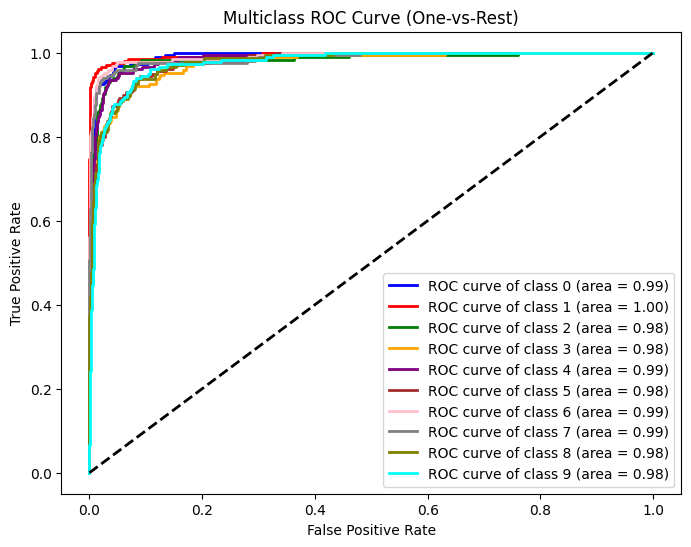

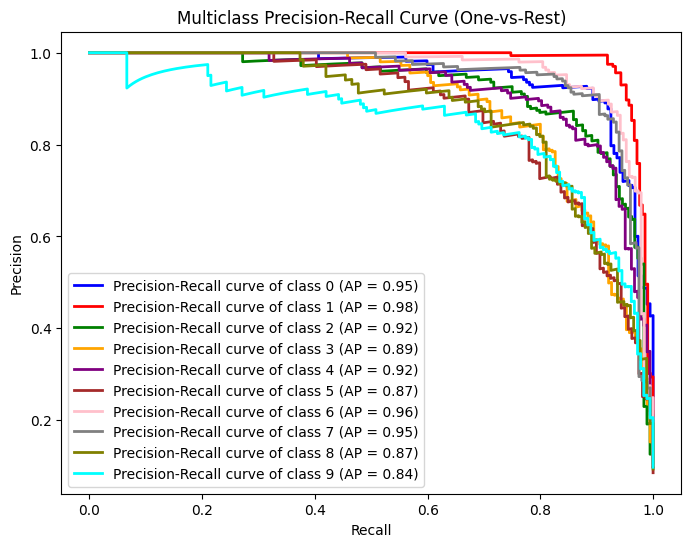

In [12]:
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

y_pred = model.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_val, y_pred))

y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], model.predict_proba(X_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], model.predict_proba(X_val)[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], model.predict_proba(X_val)[:, i])

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left")
plt.show()

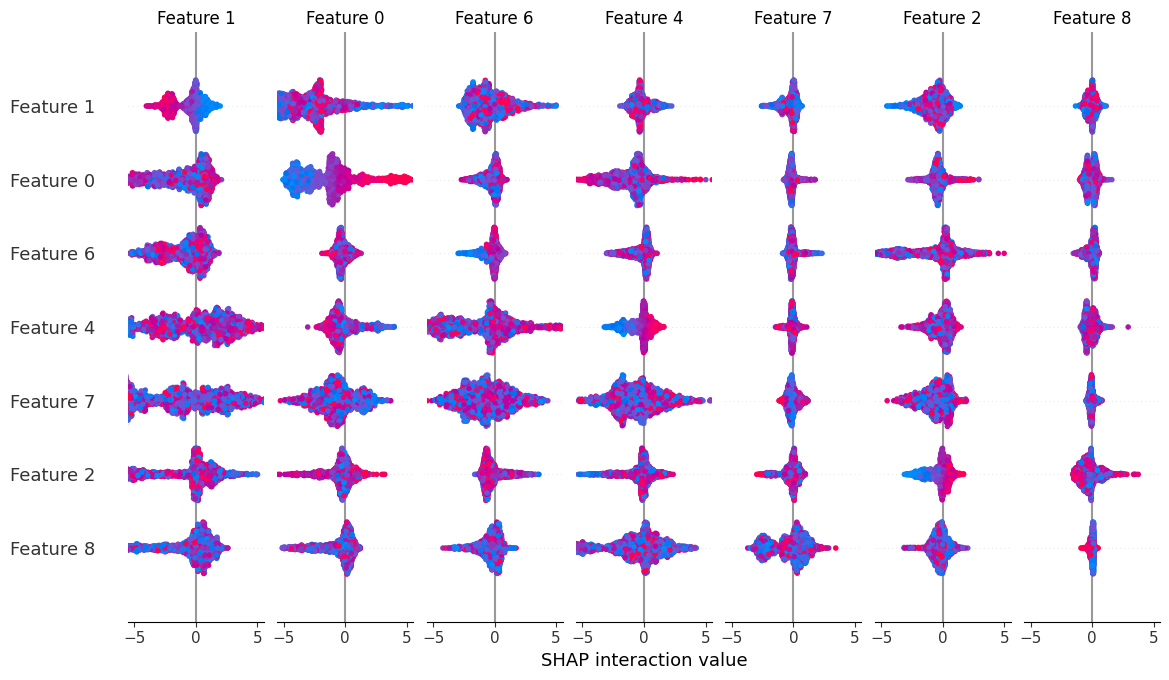

In [14]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val)


Predict on Test Data

In [13]:
def predict_test_data(model_path, test_csv_path):
    try:
        model = joblib.load(model_path)
        imputer = joblib.load('imputer.joblib')
        scaler = joblib.load('scaler.joblib')
        label_encoders = joblib.load('label_encoders.joblib')

        test_df = pd.read_csv(test_csv_path)
        for col, le in label_encoders.items():
            if col in test_df.columns:
                test_df[col] = le.transform(test_df[col].astype(str))

        X_test = test_df[features]
        X_test_imputed = imputer.transform(X_test)
        X_test_scaled = scaler.transform(X_test_imputed)

        return model.predict(X_test_scaled)
    except Exception as e:
        print(f"Prediction failed: {e}")
        return None

test_preds = predict_test_data(model_name, '/content/cosmicclassifierTest.csv')

if test_preds is not None:
    test_df = pd.read_csv('/content/cosmicclassifierTest.csv')
    if 'Planet_ID' not in test_df.columns:
        test_df['Planet_ID'] = np.arange(1, len(test_df) + 1)

    submission = pd.DataFrame({
        'Planet_ID': test_df['Planet_ID'],
        'Predicted_Class': test_preds
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission saved successfully!")
else:
    print("Failed to generate predictions")

Submission saved successfully!
